In [208]:
%config InlineBackend.figure_format = 'retina' 

In [61]:
%run -n main.py
dotenv = dict(read_dotenv('.env'))
openai.api_key = dotenv['OPENAI_TOKEN']

# label studio

In [85]:
%run -n main.py
label_client = label_studio_sdk.Client('http://localhost:8080', dotenv['LABELSTUDIO_TOKEN'])
label_client.check_connection()

{'status': 'UP'}

In [86]:
title_projects = {
    _.title: _
    for _ in label_client.list_projects()
}
translate_project = title_projects['translate']
classify_project = title_projects['classify']
sbs_project = title_projects['sbs']

# sources

## alpaca

In [ ]:
!mkdir -p data/sources/alpaca
!curl -L https://github.com/yizhongw/self-instruct/raw/main/human_eval/user_oriented_instructions.jsonl \
    > data/sources/alpaca/user_oriented_instructions.jsonl

In [ ]:
%run -n main.py
items = read_jsonl('data/sources/alpaca/user_oriented_instructions.jsonl')
alpaca_items = list(parse_alpaca(items))

## vicuna

In [ ]:
!mkdir -p data/sources/vicuna
!curl -L https://github.com/lm-sys/vicuna-blog-eval/raw/main/eval/table/question.jsonl \
    > data/sources/vicuna/question.jsonl

In [ ]:
%run -n main.py
items = read_jsonl('data/sources/vicuna/question.jsonl')
vicuna_items = list(parse_vicuna(items))

## arena

In [ ]:
!mkdir -p data/sources/arena
!curl -L curl -L https://huggingface.co/datasets/lmsys/chatbot_arena_conversations/resolve/main/data/train-00000-of-00001-cced8514c7ed782a.parquet \
    > data/sources/arena/train-00000-of-00001-cced8514c7ed782a.parquet

In [ ]:
%run -n main.py
records = pd.read_parquet('data/sources/arena/train-00000-of-00001-cced8514c7ed782a.parquet').itertuples()
arena_items = list(parse_arena(records))

# orig

In [ ]:
orig_items = alpaca_items + vicuna_items

In [ ]:
instruction_items = {
    _['instruction']: _
    for _ in arena_items
    if _['lang'] == 'English'
}
orig_items.extend(random.sample(list(instruction_items.values()), 1000))

In [14]:
write_json('data/orig.json', orig_items)

In [15]:
orig_items = read_json('data/orig.json')
random.sample(orig_items, 5)

[{'id': 'c189117c-b2a1-4ac9-9f0e-06370cfe8b6b',
  'source': 'arena',
  'source_id': 'adccaf90b7904fdeb56a1da9150c2492',
  'lang': 'English',
  'instruction': 'Let\'s think about writing a Python script step by step. \n\n1) Analyze and define the use case. What does the script need to accomplish? \n\n2) Analyze the required parameters? What does it need to know? How can it get the parameters? \n\n3) Define functions for use cases.\n\n4) Execute the script if it is running as the main module.\n\nHere is an example script for saving a message to a file:\n\nimport os\n\ndef get_user_input():\n    message = input("Please enter your message: ")\n    file_name = input("Please enter the file name: ")\n    return message, file_name\n\ndef save_message_to_file(message, file_name):\n    with open(file_name, \'w\') as file:\n        file.write(message)\n    print(f"Message saved to {file_name}")\n\ndef main():\n    message, file_name = get_user_input()\n    save_message_to_file(message, file_name)

# tasks

In [ ]:
task_items = read_json('data/tasks.json')
id_task_items = {_['id']: _ for _ in task_items}

In [ ]:
task_items.extend(
    {
        'id': _['id'],
        'source': _['source'],
        'instruction': None,
        'category': None
    }
    for _ in orig_items
    if _['source'] == 'arena'
)

In [ ]:
write_json('data/tasks.json', task_items)

# translate

In [ ]:
translate_items = [
    {
        'id': _['id'],
        'instruction': _['instruction'],
        'answer': None
    }
    for _ in orig_items
    if _['source'] == 'arena'
]
id_translate_items = {_['id']: _ for _ in translate_items}

## auto

In [ ]:
%run -n main.py
items = [_ for _ in translate_items if not _['answer']]
queue = iter(tqdm(items))
workers = [translate_worker(queue) for _ in range(10)]
await asyncio.gather(*workers);

## review

In [ ]:
label_items = [
    translate_label_item(_)
    for _ in translate_items
    if not id_task_items[_['id']]['instruction']
]
random.choice(label_items)

In [ ]:
translate_project.delete_all_tasks();
translate_project.import_tasks(label_items);

In [ ]:
for label_item in translate_project.export_tasks():
    item = label_translate_item(label_item)
    id_task_items[item['id']]['instruction'] = item['answer']

# classify

In [ ]:
classify_items = [
    {
        'id': item['id'],
        'instruction': item['instruction'],
        'category': item['category'],
        'max_sim': None
    }
    for _ in task_items
]

## auto

In [ ]:
id_embeddings = read_pickle('data/embeddings.pkl')

In [ ]:
%run -n main.py
items = [
    _ for _ in classify_items
    if _['id'] not in id_embeddings
]
for index in tqdm(range(0, len(items), 64)):
    batch = items[index:index + 64]
    texts = [_['instruction'] for _ in batch]
    embeddings = openai_embed_batch(texts)
    for item, embedding in zip(batch, embeddings):
        id_embeddings[item['id']] = np.array(embedding)

In [ ]:
write_pickle('data/embeddings.pkl', id_embeddings)

In [ ]:
target_items = [
    _ for _ in classify_items
    if _['category'] and _['category'] != 'bad instruction'
]
items = [_ for _ in classify_items if not _['category']]

for item in tqdm(items):
    max_sim = 0
    for target_item in target_items:
        sim = cosine_sim(
            id_embeddings[item['id']],
            id_embeddings[target_item['id']]
        )
        if sim > max_sim:
            max_sim = sim
            item['category'] = target_item['category']
    item['max_sim'] = max_sim

## review

In [ ]:
items = []
for item in classify_items:
    if not item['max_sim']:
        continue
        
    if item['category'] != 'enumerate':
        continue
        
    items.append(item)

items = sorted(items, key=lambda _: _['max_sim'], reverse=False)
label_items = [classify_label_item(_) for _ in items]

print('|label_items| =', len(label_items))
random.choice(label_items)

In [ ]:
classify_project.delete_all_tasks();
classify_project.import_tasks(label_items);

In [ ]:
%run -n main.py
for label_item in classify_project.export_tasks():
    item = label_classify_item(label_item)
    id_task_items[item['id']] = item['category']

# infer

In [ ]:
%run -n main.py
infer_items = read_json('data/infer.json')

In [ ]:
infer_items.extend(
    {
        'id': _['id'],
        'model': 'yagpt_chat',
        'instruction': _['instruction'],
        'answer': None
    }
    for _ in task_items
)

In [ ]:
write_json('data/infer.json', infer_items)

In [ ]:
items = [
    _ for _ in infer_items
    if _['model'] == 'yagpt_chat'
    if _['answer'] is not None
]
print('|items| =', len(items))

# random.shuffle(items)
for item in items[-10:]:
    if item['answer']:
        print(item['instruction'])
        print('----')
        print(item['answer'])
        print('---\n\n')

## turbo

In [ ]:
%run -n main.py
items = [_ for _ in infer_items if _['answer'] is None and _['model'] == 'turbo_2']
queue = iter(tqdm(items))
workers = [openai_infer_worker(queue, model='gpt-3.5-turbo-0613') for _ in range(20)]
await asyncio.gather(*workers);

## gpt4

In [ ]:
%run -n main.py
items = [_ for _ in infer_items if _['answer'] is None and _['model'] == 'gpt4_2']
queue = iter(tqdm(items))
workers = [openai_infer_worker(queue, model='gpt-4-0613', request_timeout=1200) for _ in range(20)]
await asyncio.gather(*workers);

## gigachat

In [ ]:
%run -n main.py
headers = dict(read_headers('.gigachat'))
gigachat_client = gigachat_client_init(headers)

# After ~5 min / 260 answers blocked for ~1 hour
# {'result': 'rejected', 'reason': 'UserBlocked', 'user_blocked_until': '2023-08-25T11:00:24+00:00'}

# "в полуавтоматическом режиме банят, если 3 временных бана, то могут опять решить забанить насовсем.
# Так что при временном бане лучше какое-то время  подождать."

# "из-за запросов типа "Люди умирают, когда их убивают, откуда это высказывание?". Цензор такое
# отлавливает сколько-то раз и во временный бан отправляет"

In [ ]:
%run -n main.py
items = [_ for _ in infer_items if _['answer'] is None and _['model'] == 'gigachat']
queue = iter(tqdm(items[:100]))
workers = [gigachat_infer_worker(gigachat_client, queue) for _ in range(2)]
await asyncio.gather(*workers);

## yagpt

In [ ]:
lines = !~/yandex-cloud/bin/yc iam create-token
YAGPT_TOKEN = lines[0]

lines = !~/yandex-cloud/bin/yc resource-manager folder get --name default --format json
data = json.loads(''.join(lines))
YAGPT_FOLDER_ID = data['id']

# token expires every ~12 hours

In [ ]:
%run -n main.py
yagpt_client = yagpt_client_init(YAGPT_TOKEN, YAGPT_FOLDER_ID)

In [ ]:
%run -n main.py
items = [_ for _ in infer_items if _['answer'] is None and _['model'] == 'yagpt_instruct']
queue = iter(tqdm(items))
limiter = Limiter(min_delay=1.2)
workers = [yagpt_infer_worker(yagpt_client, limiter, queue, mode='instruct') for _ in range(5)]
await asyncio.gather(*workers);

In [ ]:
%run -n main.py
items = [_ for _ in infer_items if _['answer'] is None and _['model'] == 'yagpt_chat']
queue = iter(tqdm(items))
limiter = Limiter(min_delay=1.2)
workers = [yagpt_infer_worker(yagpt_client, limiter, queue, mode='chat') for _ in range(5)]
await asyncio.gather(*workers);

# sbs

In [265]:
sbs_items = read_json('data/sbs.json')

In [330]:
id_task_items = {_['id']: _ for _ in task_items}

id_model_answers = defaultdict(dict)
for item in infer_items:
    id_model_answers[item['id']][item['model']] = item['answer']

key_sbs_items = {}
for item in sbs_items:
    key = item['id'], item['model_a'], item['model_b']
    key_sbs_items[key] = item

In [331]:
model_a = 'turbo_2'
for item in infer_items:
    id, model_b = item['id'], item['model']
    if model_a == model_b:
        continue

    if model_b in ('yagpt_chat', 'yagpt_alisa'):
        continue

    key = id, model_a, model_b
    if key in key_sbs_items:
        continue

    answer_a = id_model_answers[id][model_a]
    answer_b = id_model_answers[id][model_b]
    if not answer_a or not answer_b:
        continue

    task_item = id_task_items[id]
    if task_item['source'] not in ('alpaca', 'vicuna'):
        continue

    instruction = task_item['instruction']
    sbs_items.append({
        'id': id,
        'model_a': model_a,
        'model_b': model_b,

        'instruction': instruction,
        'answer_a': answer_a,
        'answer_b': answer_b,

        'result': None
    })

In [355]:
write_json('data/sbs.json', sbs_items)

## auto

In [340]:
%run -n main.py
items = [_ for _ in sbs_items if not _['result']]
random.shuffle(items)
queue = iter(tqdm(items[:100]))
workers = [sbs_worker(queue) for _ in range(10)]
await asyncio.gather(*workers);

100%|██████████| 100/100 [02:08<00:00,  1.29s/it]
Timeout(message='Request timed out', http_status=None, request_id=None)
Timeout(message='Request timed out', http_status=None, request_id=None)


## review

In [346]:
%run -n main.py
items = []
for item in sbs_items:
    if item['result']:
        items.append(item)
    
random.shuffle(items)
label_items = [sbs_label_item(_) for _ in items]

print('|label_items| =', len(label_items))
random.choice(label_items)

|label_items| = 105


{'data': {'id': '4ab1d8b0-ee0d-4e68-bed6-fcfe96aea6b7',
  'model_a': 'turbo_2',
  'model_b': 'gpt4_2',
  'instruction': 'Извлеките метод, использованный в исследовании. Укажите точные предложения, которые обсуждают этот метод.\n\n"We present a state-of-the-art speech recognition system developed using end-to-end deep learning. Our architecture is significantly simpler than traditional speech systems, which rely on laboriously engineered processing pipelines; these traditional systems also tend to perform poorly when used in noisy environments. In contrast, our system does not need hand-designed components to model background noise, reverberation, or speaker variation, but instead directly learns a function that is robust to such effects. We do not need a phoneme dictionary, nor even the concept of a "phoneme." Key to our approach is a well-optimized RNN training system that uses multiple GPUs, as well as a set of novel data synthesis techniques that allow us to efficiently obtain a lar

In [347]:
sbs_project.delete_all_tasks();
sbs_project.import_tasks(label_items);

In [119]:
%run -n main.py
for item in sbs_items:
    key = item['id'], item['model_a'], item['model_b']
    key_sbs_items[key] = item

for label_item in sbs_project.export_tasks():
    item = label_sbs_item(label_item)
    key = item['id'], item['model_a'], item['model_b']
    key_sbs_items[key]['result'] = item['result']

# plot

In [352]:
result_scores = {
    'A': -1,
    'AC': -0.5,
    'C': 0,
    'BC': 0.5,
    'B': 1,
}

model_scores = defaultdict(list)
for item in sbs_items:
    result = item['result']
    if not result:
        continue

    score = result_scores[item['result']]
    model_scores[item['model_b']].append(score)

model_stats = {}
for model, scores in model_scores.items():
    samples = []
    for _ in range(500):
        accum = 0
        for score in random.choices(scores, k=len(scores)):
            accum += score
        samples.append(accum / len(scores))
        
    samples.sort()
    size = len(samples)
    model_stats[model] = {
        'median': samples[round(size / 2)],
        'lower_bound': samples[round(size * 0.05)],
        'upper_bound': samples[round(size * 0.95)],
    }
    
model_stats['turbo_2'] = {'median': 0, 'lower_bound': 0, 'upper_bound': 0}

In [353]:
model_stats

{'gpt4_2': {'median': 0.07407407407407407,
  'lower_bound': -0.18518518518518517,
  'upper_bound': 0.3148148148148148},
 'gigachat': {'median': -0.890625,
  'lower_bound': -0.96875,
  'upper_bound': -0.796875},
 'yagpt_instruct': {'median': -0.4375,
  'lower_bound': -0.6666666666666666,
  'upper_bound': -0.1875},
 'saiga2_7b': {'median': -0.7142857142857143,
  'lower_bound': -0.9285714285714286,
  'upper_bound': -0.42857142857142855},
 'saiga2_13b': {'median': -0.875, 'lower_bound': -1.0, 'upper_bound': -0.625},
 'turbo_2': {'median': 0, 'lower_bound': 0, 'upper_bound': 0}}

Text(0.5, 0, '(A лучше B - B лучше A) / всего заданий')

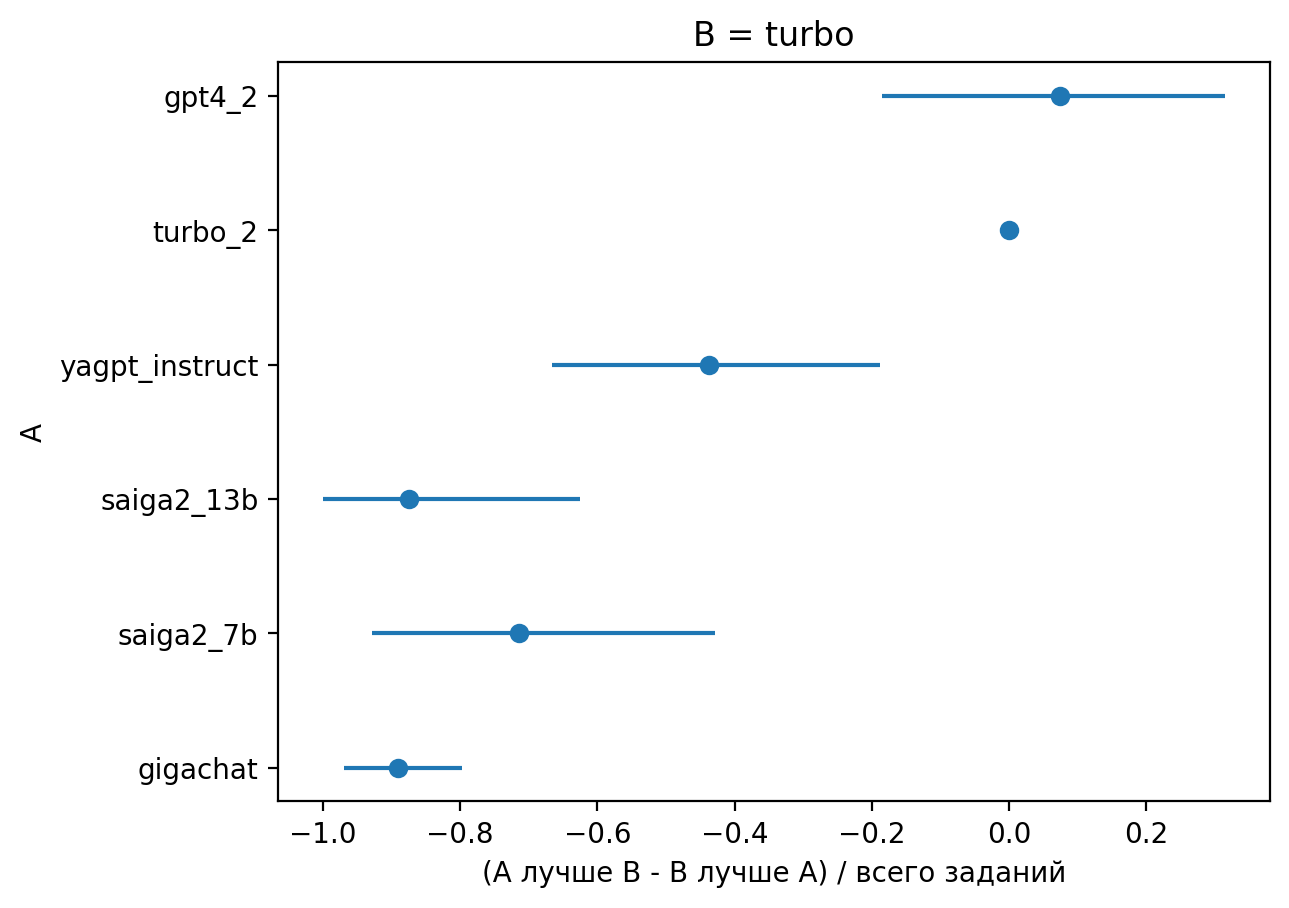

In [354]:
%run -n main.py

models_order = [
    'gigachat',

    'saiga2_7b',
    'saiga2_13b',

#     'yagpt_alisa',
#     'yagpt_chat',
    'yagpt_instruct',
    
    'turbo_2',
    'gpt4_2'
]

xs = []
ys = []
xerr_lower = []
xerr_upper = []
for y, model in enumerate(models_order):
    ys.append(y)

    stats = model_stats[model]
    xs.append(stats['median'])
    xerr_lower.append(stats['median'] - stats['lower_bound'])
    xerr_upper.append(stats['upper_bound'] - stats['median'])

fig, ax = plt.subplots()
ax.errorbar(
    x=xs,
    y=ys,
    xerr=[xerr_lower, xerr_upper],
    fmt='o'
)
ax.set_yticks(ys, models_order)
ax.set_title('B = turbo')
ax.set_ylabel('A')
ax.set_xlabel('(A лучше B - B лучше A) / всего заданий')

# show samples

In [ ]:
%run -n main.py
source_items = defaultdict(list)
for item in task_items:
    source_items[item['source']].append(item)

with open('data/tasks.md', 'w') as file:
    with redirect_stdout(file):
        for source in ['alpaca', 'vicuna', 'arena']:
            print(f'<h1>{source}</h1>')

            items = [_ for _ in source_items[source] if _['category']]
            for item in random.sample(items, 30):
                category = item['category']
                print(f'<code>#{category}</code>')
                print('<br/>')
                instruction = html.escape(item['instruction'])
                print('<br/>\n'.join(instruction.splitlines()))
                print('<br/><br/>')